### Import required libraries

In [ ]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import DynamicEdgeConv, MessagePassing, knn_graph
from torch.nn import Sequential as Seq, Linear, ReLU

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Normalizer

### Selecting Device

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

### Load traning and test data and Concatinate them

In [ ]:
df_train = pd.read_csv('trainingData.csv')

In [ ]:
missing = 0.0
if missing > 0:
    df_train = df_train.sample(frac=1-missing, random_state=42)

In [ ]:
df_val = pd.read_csv('validationData.csv')

train_numb = len(df_train)
test_numb = len(df_val)

df = pd.concat([df_train, df_val])
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,x,y,x_scaled,y_scaled
0,0,0,0,0,0,0,0,0,0,0,...,1,106,2,2,23,1371713733,715398.093448,5.392590e+06,-56.230829,51.547814
1,0,0,0,0,0,0,0,0,0,0,...,1,106,2,2,23,1371713691,715400.939587,5.392605e+06,-53.384690,66.623963
2,0,0,0,0,0,0,0,7,0,0,...,1,103,2,2,23,1371714095,715413.151558,5.392622e+06,-41.172719,84.129571
3,0,0,0,0,0,0,0,0,0,0,...,1,102,2,2,23,1371713807,715409.819729,5.392605e+06,-44.504548,66.817394
4,0,0,0,0,0,0,0,0,0,0,...,0,122,2,11,13,1369909710,715328.549585,5.392655e+06,-125.774691,117.264838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,13,1381156711,715568.336653,5.392457e+06,114.012377,-81.326600
1107,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,13,1381156730,715571.145382,5.392453e+06,116.821105,-85.077311
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1381247781,715327.944283,5.392567e+06,-126.379994,29.325570
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1381247807,715328.520951,5.392569e+06,-125.803326,31.247004


### Create Classes for classification

In [ ]:
df['CLASS'] = df['BUILDINGID'].astype(str) + df['FLOOR'].astype(str)
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,x,y,x_scaled,y_scaled,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,106,2,2,23,1371713733,715398.093448,5.392590e+06,-56.230829,51.547814,12
1,0,0,0,0,0,0,0,0,0,0,...,106,2,2,23,1371713691,715400.939587,5.392605e+06,-53.384690,66.623963,12
2,0,0,0,0,0,0,0,7,0,0,...,103,2,2,23,1371714095,715413.151558,5.392622e+06,-41.172719,84.129571,12
3,0,0,0,0,0,0,0,0,0,0,...,102,2,2,23,1371713807,715409.819729,5.392605e+06,-44.504548,66.817394,12
4,0,0,0,0,0,0,0,0,0,0,...,122,2,11,13,1369909710,715328.549585,5.392655e+06,-125.774691,117.264838,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381156711,715568.336653,5.392457e+06,114.012377,-81.326600,23
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381156730,715571.145382,5.392453e+06,116.821105,-85.077311,23
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381247781,715327.944283,5.392567e+06,-126.379994,29.325570,00
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381247807,715328.520951,5.392569e+06,-125.803326,31.247004,00


In [ ]:
no_out = len(df['CLASS'].unique())

In [ ]:
df_y = df[["CLASS"]]
df_y

,CLASS
0,12
1,12
2,12
3,12
4,00
...,...
1106,23
1107,23
1108,00
1109,00


In [ ]:
enc = OrdinalEncoder(dtype=np.int32)
y = enc.fit_transform(df_y['CLASS'].values.reshape(-1,1))
y = y.reshape(-1,)

In [ ]:
y.max()

12

In [ ]:
y

array([6, 6, 6, ..., 0, 0, 0])

### Seperate Input and Output

In [ ]:
df_x = df.iloc[: , :520]

df_x

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Split data into train and test sets
X_train = df_x[:len(df_train)]
X_test = df_x[len(df_train):]
y_train = y[:len(df_train)]
y_test = y[len(df_train):]

### Scale the input features

In [ ]:
norm_scl = Normalizer()

norm_scl.fit(X_train)

Normalizer()

In [ ]:
df_x = norm_scl.transform(df_x)

In [ ]:
X_train = norm_scl.transform(X_train)
X_test = norm_scl.transform(X_test)

In [ ]:
print("Normalized X_train:")
print(X_train[0])

Normalized X_train:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.30801265
 0.29968799 0.         0.         0.         0.         0.
 0.         0.         0.   

### KNN Classifier

In [ ]:
acc_list =[]
for K in range(1, 60):
    knn = KNeighborsClassifier(n_neighbors=K, weights='distance')

    # Train the model on the training set
    knn.fit(X_train, y_train)

    # Predict on the test set
    y_pred = knn.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    acc_list.append(acc.item())
    print("K = ", K, "Accuracy_score: {:.4f}".format(acc))

K =  1 Accuracy_score: 0.9253
K =  2 Accuracy_score: 0.9253
K =  3 Accuracy_score: 0.9244
K =  4 Accuracy_score: 0.9253
K =  5 Accuracy_score: 0.9271
K =  6 Accuracy_score: 0.9280
K =  7 Accuracy_score: 0.9289
K =  8 Accuracy_score: 0.9280
K =  9 Accuracy_score: 0.9307
K =  10 Accuracy_score: 0.9298
K =  11 Accuracy_score: 0.9307
K =  12 Accuracy_score: 0.9298
K =  13 Accuracy_score: 0.9325
K =  14 Accuracy_score: 0.9316
K =  15 Accuracy_score: 0.9352
K =  16 Accuracy_score: 0.9334
K =  17 Accuracy_score: 0.9343
K =  18 Accuracy_score: 0.9343
K =  19 Accuracy_score: 0.9316
K =  20 Accuracy_score: 0.9325
K =  21 Accuracy_score: 0.9307
K =  22 Accuracy_score: 0.9307
K =  23 Accuracy_score: 0.9316
K =  24 Accuracy_score: 0.9316
K =  25 Accuracy_score: 0.9325
K =  26 Accuracy_score: 0.9325
K =  27 Accuracy_score: 0.9325
K =  28 Accuracy_score: 0.9325
K =  29 Accuracy_score: 0.9334
K =  30 Accuracy_score: 0.9325
K =  31 Accuracy_score: 0.9325
K =  32 Accuracy_score: 0.9343
K =  33 Accuracy_

Text(0.5, 1.0, 'best accuracy: 0.9378937893789379')

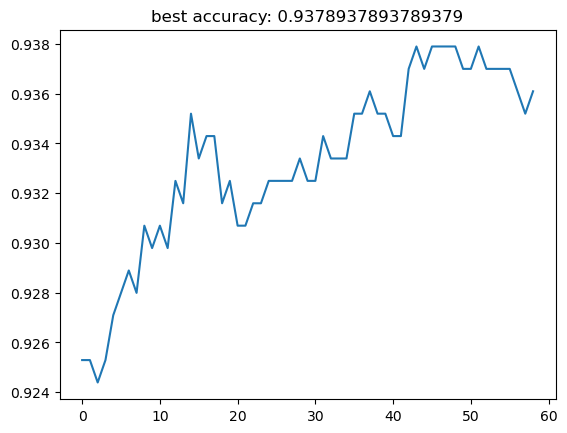

In [ ]:
plt.plot(acc_list)
plt.title(f"best accuracy: {max(acc_list)}")
# plt.savefig(f"result_part/knn_missing_{missing}.png")

### MLP Classifier

In [ ]:
def mlp_call(h_layer):
    mlp = MLPClassifier(hidden_layer_sizes=h_layer, activation='relu', solver='adam', random_state=42)
    mlp.fit(X_train, y_train)
    y_pred = mlp.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Hidden layer: {h_layer} \tAccuracy: {accuracy}")
    return accuracy

In [ ]:
h_layers = [(32), (64), (64, 32), (128), (128, 32), (256, 32), (256, 64), (512, 64), (512, 256, 64), (1024, 512, 256), (1024, 16)]
mlp_res = []
for h_layer in h_layers:
    mlp_res.append(mlp_call(h_layer))

Hidden layer: 32 	Accuracy: 0.9234923492349235
Hidden layer: 64 	Accuracy: 0.9225922592259226
Hidden layer: (64, 32) 	Accuracy: 0.9162916291629163
Hidden layer: 128 	Accuracy: 0.9144914491449145
Hidden layer: (128, 32) 	Accuracy: 0.918991899189919
Hidden layer: (256, 32) 	Accuracy: 0.9198919891989199
Hidden layer: (256, 64) 	Accuracy: 0.9234923492349235
Hidden layer: (512, 64) 	Accuracy: 0.927992799279928
Hidden layer: (512, 256, 64) 	Accuracy: 0.9270927092709271
Hidden layer: (1024, 512, 256) 	Accuracy: 0.9270927092709271
Hidden layer: (1024, 16) 	Accuracy: 0.9270927092709271


FileNotFoundError: [Errno 2] No such file or directory: '../results/uji_result/mlp_missing_0.0.png'

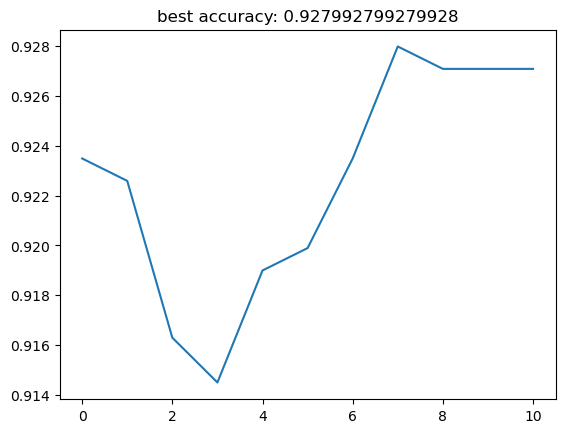

In [ ]:
plt.plot(mlp_res)
plt.title(f"best accuracy: {max(mlp_res)}")

### SVM Classifier

In [ ]:
def svm_call(c):
    svm = SVC(kernel='rbf', C=c, random_state=42)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    svm_acc = accuracy_score(y_test, y_pred)
    print(f"C = {c} \tAccuracy: {svm_acc}")
    return svm_acc


In [ ]:
cs = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5]
svm_res = []
for c in cs:
    svm_res.append(svm_call(c))

C = 0.5 	Accuracy: 0.9504950495049505
C = 0.6 	Accuracy: 0.9513951395139514
C = 0.7 	Accuracy: 0.9513951395139514
C = 0.8 	Accuracy: 0.9522952295229523
C = 0.9 	Accuracy: 0.9504950495049505
C = 1.0 	Accuracy: 0.9504950495049505
C = 1.1 	Accuracy: 0.9513951395139514
C = 1.2 	Accuracy: 0.9513951395139514
C = 1.3 	Accuracy: 0.9513951395139514
C = 1.4 	Accuracy: 0.9504950495049505
C = 1.5 	Accuracy: 0.9504950495049505


FileNotFoundError: [Errno 2] No such file or directory: '../results/uji_result/svm_missing_0.0.png'

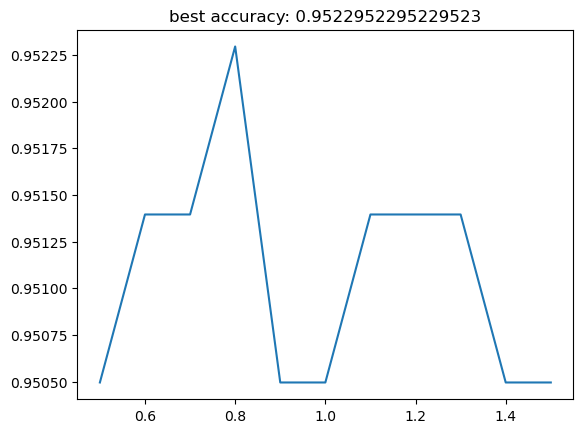

In [ ]:
plt.plot(cs, svm_res)
plt.title(f"best accuracy: {max(svm_res)}")
